In [ ]:
!git clone https://github.com/Aruiz99/MEDCONECTA_test.git

Cloning into 'MEDCONECTA_test'...
fatal: could not read Username for 'https://github.com': No such device or address


# Define functions and dependencies

In [ ]:
!pip install fast-histogram
!pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 36.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import dilation, square
import math
import fast_histogram
import matplotlib.colors as colors
import rasterio
import os
from PIL import Image
import multiprocessing
from natsort import natsorted
import geopandas as gpd
from rasterio.plot import show
from rasterio.features import rasterize

# Define functions
def shapefile_rasterize(vector_file, raster_file, id_field):
    """
        Rasterizes the vector file based on the reference raster file. It requires the name of the field containing
        the ID(which needs to be numeric).

        Parameters
        ----------
        vector_file : str
            File path to the vector file (.shp).
        raster_file : str
            File path to the reference raster file (.tif).
        id_field : str
            Name of the field containing the ID (should be numeric).

        Returns
        -------
        numpy.ndarray
            Rasterized array representing the vector file based on the reference raster.

        """

    # Open the vector file using GeoPandas
    gdf = gpd.read_file(vector_file)

    # Open the reference raster file with rasterio to obtain geospatial information
    with rasterio.open(raster_file) as src:
        profile = src.profile

        # Create an array of zeros with the same dimensions as the reference raster
        rasterize_array = np.zeros((src.height, src.width), dtype=np.float32)

        # Rasterize the vector file using the ID field values
        for id_value in gdf[id_field]:
            shapes = ((geom, value) for geom, value in zip(gdf.geometry, gdf[id_field]))
            burned = rasterize(shapes, out=rasterize_array, fill=0, transform=src.transform)

    return rasterize_array

def get_boundaries(array):
    '''
    Given a numpy.ndarray or a binary image, calculates its boundaries.

    Parameters
    ----------
    array : numpy.ndarray
        Binary image in array-like format.

    Returns
    -------
    numpy.ndarray
        Image of the boundaries in array-like format.
    '''
    boundaries = dilation(array,square(3))- array
    return boundaries

def get_hist(array, categorias):
    '''
       Given a numpy.ndarray, computes the histogram of the provided categories.

       Parameters
       ----------
       array : numpy.ndarray
           Image or vector in np.array format.
       categorias : list
           List of categories.

       Returns
       -------
       numpy.ndarray
           Histogram of the image given the provided categories.
       '''
    f = fast_histogram.histogram1d(array, bins=len(categorias), range=(categorias[0], categorias[-1] + 1))
    return f

def distancia_cuerda(f1,f2):

    '''
    Given two vectors (of frequencies), computes the Orloci Cord Distance between them.
    The formula used for the calculation is: 𝐷 = √(2(1−(∑_(𝑖=1)^𝑛〖𝑦_𝑖1∙𝑦_𝑖2〗)/√(∑_(𝑖=1)^𝑛〖𝑦_𝑖1^2〗∙∑_(𝑖=1)^𝑛〖𝑦_𝑖2^2〗)))

    Parameters
    ----------
    f1 : numpy.ndarray
        Frequency vector 1.
    f2 : numpy.ndarray
        Frequency vector 2.

    Returns
    -------
    float
        Value of the Orloci Cord Distance between the two given vectors.
    '''

    denom = math.sqrt((f1 * f1).sum()*(f2 * f2).sum())
    num = (f1 * f2).sum()
    orloci = math.sqrt(2*(1-(num/denom)))
    return orloci

def orloci_coeficient(zNucleo, dRue, LIC, boundaries, categories, size):
    '''
    Given a specific seed within the seed map, it calculates the Orloci coefficient for each point along its boundary.
    To calculate the Orloci coefficient, two histograms are used: the first corresponds to the seed's histogram based
    on the land condition map, and the second corresponds to the histogram of all points within a specific-sized kernel
    using the same land condition map.

    Parameters
    ----------
    zNucleo : numpy.ndarray
        Initial seeds that will grow based on the affinity with the surroundings.
    dRue : numpy.ndarray
        Map of land condition that sets a category for each pixel.
    LIC : numpy.ndarray
        Corresponds to one specific seed inside the seed map.
    boundaries : numpy.ndarray
        Image of the boundaries.
    categories : list
        List of categories.
    size : int
        Size of the employed kernel.

    Returns
    -------
    numpy.ndarray
        Map of the Orloci Coefficient Values for the seed's boundaries.
    '''

    # Get the coordinates of the pixel boundaries
    coords = np.argwhere(boundaries)
    orloci_mask = np.zeros_like(boundaries).astype('float')

    # Calculate the seed's histogram
    dRueLic = dRue * LIC
    f1 = get_hist(dRueLic, categories)

    # Define the mask edges based on whether it is odd or even
    if size % 2 != 0:
        low = size // 2
        high = size // 2 + 1
    # When it's even, we arbitrarily center it in the bottom right corner
    else:
        low = size // 2
        high = size // 2

    for i in coords:
        x = i[0]
        y = i[1]
        dRueNxN = dRue[x-low: x+high, y-low: y+high]

        # Calculate the Orloci cord distance coefficient and assign it
        if (np.any(dRueNxN != 0)): # At least one non-zero value to compare
            f2 = get_hist(dRueNxN, categories)
            value = distancia_cuerda(f1,f2)
            orloci_mask[x][y] = value + 10  # The 10 is an arbitrary number to fix the zero bug (To fix it properly, change it to nodata)
    return orloci_mask

def growing_ameboide(zNucleo, boundaries, orloci_thresholded_mask):
    """
        Grows amoeboid regions based on the Orloci thresholded mask.
        This function combines the existing regions with the new regions determined by the Orloci thresholded mask.
        It calculates and assigns the updated areas to create the new zones.

        Parameters
        ----------
        zNucleo : numpy.ndarray
            Array representing the existing regions.
        boundaries : numpy.ndarray
            Array representing the boundaries.
        orloci_thresholded_mask : numpy.ndarray
            Mask generated by applying a threshold to the Orloci coefficients.

        Returns
        -------
        numpy.ndarray
            Updated zones resulting from the combination of existing regions and new regions based on the Orloci threshold.

        """
    newZones = zNucleo + (boundaries * orloci_thresholded_mask)
    return newZones

def escenario_cero(zNucleo, dRue, id, size, threshold):
    """
       Performs a growing algorthim where the process stops when no pixel is updated according to the Orloci criteria.
       Given a specific seed within the seed map, it calculates the Orloci coefficient for each point along its boundary.
       To calculate the Orloci coefficient, two histograms are used: the first corresponds to the seed's histogram based
       on the land condition map, and the second corresponds to the histogram of all points within a specific-sized kernel
       using the same land condition map.

       Parameters
       ----------
       zNucleo : numpy.ndarray
           Array representing the intial seed map.
       dRue : numpy.ndarray
           Array representing the land condition map.
       id : int
           Value identifying a specific seed within the seed map.
       size : int
           Size of the kernel used for calculate the Orloci Coefficient between the seed and its sourrandings.
       threshold : int
           Threshold value used to determine the pixels to consider based on the Orloci criteria.

       Returns
       -------
       numpy.ndarray
           Final growing map of the seed based on the land condition map and the parameters size and threshold
       """

    # Initial variables to start the loop
    LIC = (zNucleo == id).astype('int')
    newZones = LIC
    orloci_thresholded_mask = np.array([1])
    i = 0

    # Assigning the stopping condition (no pixel gets updated according to Orloci criteria)
    while not (np.all(orloci_thresholded_mask == 0)):
        i += 1

        # Calculating the boundaries
        boundaries = get_boundaries(newZones)

        # Preventing extension over the edges
        boundaries = boundaries * (dRue > 0)

        # Assigning the number of categories in map condition map
        categories = np.arange(1, dRue.max()+1)

        # Calculating Orloci cord distance and assigning each value to its boundary pixel
        orloci_mask = orloci_coeficient(newZones, dRue, LIC, boundaries, categories, size)

        # Defining similar points based on the threshold
        orloci_thresholded_mask = (orloci_mask >= 10) & (orloci_mask <= 10 + threshold) # 10 fixes the bug of 0 (fix to nodata)

        # Adding new pixels to the map
        newZones = growing_ameboide(newZones, boundaries, orloci_thresholded_mask)

    return newZones


def escenario_cero_images(zNucleo, dRue, id, size, threshold, dir):
    """
       Same as escenario_cero but it saves all the growing steps as .png file saved in dir

       Parameters
       ----------
       zNucleo : numpy.ndarray
           Array representing the intial seed map.
       dRue : numpy.ndarray
           Array representing the land condition map.
       id : int
           Value identifying a specific seed within the seed map.
       size : int
           Size of the kernel used for calculate the Orloci Coefficient between the seed and its sourrandings.
       threshold : int
           Threshold value used to determine the pixels to consider based on the Orloci criteria.
       dir: str
           Directory to save the all the growing steps as .png

       Returns
       -------
       numpy.ndarray
           Final growing map of the seed based on the land condition map and the parameters size and threshold
       """

    # Define colors to be use
    colors_list = ['white', '#99649f', '#d20000', '#845c51', '#be8265', '#a69e68', '#d5cea4', '#aec6a8', '#6aae76',
                   '#5f817e', '#aeb1d2']
    cmap = colors.ListedColormap(colors_list)

    colors_list_bk = ['white', '#99649f', '#d20000', '#845c51', '#be8265', '#a69e68', '#d5cea4', '#aec6a8', '#6aae76',
                   '#5f817e', '#aeb1d2', '#2e221f']
    cmap_bk = colors.ListedColormap(colors_list_bk)

    # Initial variables to start the loop
    LIC = (zNucleo == id).astype('int')
    newZones = LIC
    orloci_thresholded_mask = np.array([1])
    i = 0

    # Save initial position
    imagen_inicial = newZones * dRue
    imagen_inicial[get_boundaries(LIC) == 1] = 11
    plt.imshow(dRue > 0, interpolation=None, alpha=0.50, cmap='Greys')
    plt.imshow(zNucleo > 0, alpha=0.50, interpolation=None, cmap=cmap)
    plt.imshow(imagen_inicial, cmap=cmap_bk, alpha=0.70, vmin=0, vmax=11)
    plt.axis('off')
    plt.savefig(dir + str(i) + '.png', dpi=1000.0)
    plt.close()

    # Assigning the number of categories in map condition map
    categories = np.arange(1, dRue.max() + 1)

    # Assigning the stopping condition (no pixel gets updated according to Orloci criteria)
    while not (np.all(orloci_thresholded_mask == 0)):
        i += 1

        # Calculating the boundaries
        boundaries = get_boundaries(newZones)

        # Preventing extension over the edges
        boundaries = boundaries * (dRue > 0)

        # Calculating Orloci cord distance and assigning each value to its boundary pixel
        orloci_mask = orloci_coeficient(newZones, dRue, LIC, boundaries, categories, size)

        # Defining similar points based on the threshold
        orloci_thresholded_mask = (orloci_mask >= 10) & (orloci_mask <= 10 + threshold) # 10 fixes the bug of 0 (fix to nodata)

        # Adding new pixels to the map
        newZones = growing_ameboide(newZones, boundaries, orloci_thresholded_mask)

        img = newZones * dRue
        img[get_boundaries(LIC) == 1] = 11
        plt.imshow(dRue > 0, interpolation=None, alpha=0.50, cmap='Greys')
        plt.imshow(zNucleo > 0, alpha=0.50, interpolation=None, cmap=cmap)
        plt.imshow(img, cmap = cmap_bk, alpha = 0.7, vmin= 0, vmax= 11)
        plt.axis('off')
        plt.savefig(dir + str(i) + '.png', dpi = 1000.0)
        plt.close()
        print(i)

    return newZones

def save_image(zNucleo, dRue, growingLIC, id, dir):
    """
           Saves the final postion of the growing algorithm in PNG format.

           Parameters
           ----------
           zNucleo : numpy.ndarray
               Array representing the intial seed map.
           dRue : numpy.ndarray
               Array representing the land condition map.
           growingLIC : numpy.ndarray
               Array representing the final position of the growing algorithm.
           id : int
               Value identifying a specific seed within the seed map.
           dir : str
               Directory to save the final image.

           Returns
           -------
           numpy.ndarray
               Final growing image of the seed based on the land condition map
           """
    # Define colors to be use
    colors_list = ['white', '#99649f', '#d20000', '#845c51', '#be8265', '#a69e68', '#d5cea4', '#aec6a8', '#6aae76',
                   '#5f817e', '#aeb1d2']
    cmap = colors.ListedColormap(colors_list)

    colors_list_bk = ['white', '#99649f', '#d20000', '#845c51', '#be8265', '#a69e68', '#d5cea4', '#aec6a8', '#6aae76',
                      '#5f817e', '#aeb1d2', '#2e221f']
    cmap_bk = colors.ListedColormap(colors_list_bk)

    # Define LIC
    LIC = (zNucleo == id).astype('int')

    # Create directory to save
    direct = dir + '/ImagesPNG'
    if not os.path.exists(direct):
        os.makedirs(direct)

    # Save final position
    final_image = growingLIC * dRue
    final_image[get_boundaries(LIC) == 1] = 11
    plt.imshow(dRue > 0, interpolation=None, alpha=0.50, cmap='Greys')
    plt.imshow(zNucleo > 0, alpha=0.50, interpolation=None, cmap=cmap)
    plt.imshow(final_image, cmap=cmap_bk, alpha=0.70, vmin=0, vmax=11)
    plt.axis('off')
    plt.savefig(direct + '/' + str(id) + '.png', dpi=1000.0)
    plt.close()

    return None


# Define multiprocessing functions
def processing_id(ids):
    """
        Defines the processing_id function, calculating the growing algorithm for each ID.

        Parameters
        ----------
        ids : list
            List of IDs for which the growing function needs to be computed.

        Returns
        -------
        None
            This function does not return any value; it performs operations to calculate scenario zero for each ID and
            saves the results as GeoTIFF files.

        """
    # Create dir to save the tiff files
    if not os.path.exists(directory + '/ImagesTIFF'):
        os.makedirs(directory + '/ImagesTIFF')

    for id in ids:
        # Execute the algorithm
        escenario_0 = escenario_cero(zNucleo, dRue, id=id, size=size, threshold=threshold)

        # Save final image as .png
        save_image(zNucleo, dRue, growingLIC=escenario_0, id=id, dir=directory)

        # Save the final result in a GeoTIFF layer using the original input as a template
        with rasterio.open(raster_file) as rst:
            profile = rst.profile

        with rasterio.open(directory + '/ImagesTIFF' + '/' + str(id) + '.tif', 'w', **profile) as new_rst:
            new_rst.write(escenario_0, 1)  # If space becomes an issue (new_rst.write(escenario_0.astype(rasterio.uint8), 1)

    return None


def get_escenario_cero(zNucleo, dRue, size, threshold, directory):
    """
    Computes the growing algorith for all the seeds provided in zNucleo using multiprocessing.

    Parameters
    ----------
    zNucleo : numpy.ndarray
        Array corresponding to the seed map.
    dRue : numpy.ndarray
        Array containing land condition information.
    size : int
        Size parameter for the calculation.
    threshold : int
        Threshold parameter used in the calculation.
    directory : str
        Directory path for storing the computed results.

    Returns
    -------
    None
        This function does not return any value; it performs operations to compute and save scenario zero results.

    Notes
    -----
    - This function divides the IDs into subsets and computes the scenario zero using multiprocessing.
    - It opens and overlays all the images, saves the final result as a GeoTIFF file, and generates an image of the result.

    The function first selects all IDs from zNucleo (excluding the background), then divides the IDs and calculates
    them using multiprocessing. It then opens all images, overlays them, and saves the final result as a GeoTIFF file
    named 'resultado.tif'. Additionally, it generates an image 'resultado.png' that visualizes the computed scenario
    zero along with land condition information and vector boundary contours.
    """

    # Select all the IDs from zNucleo (excluding the background)
    ids = list(np.unique(zNucleo).astype('int'))
    ids.remove(0)  # Zero represents the background

    # Divide the IDs and perform multiprocessing
    if __name__ == '__main__':

        # Divide the list of IDs into multiple subsets
        num_procesos = multiprocessing.cpu_count()
        chunks = [[] for _ in range(num_procesos)]
        for i, id in enumerate(ids):
            chunks[i % num_procesos].append(id)

        # Execute the function in parallel
        with multiprocessing.Pool(processes=num_procesos) as pool:
            result = pool.map_async(processing_id, chunks)
            result.wait()

            # Open all images and overlay them
            resultado = np.zeros_like(zNucleo)
            for file in natsorted(os.listdir(directory + '/ImagesTIFF')):
                if file.endswith(".tif"):
                    if not file.startswith('resultado'):
                        x = np.asarray(Image.open(os.path.join(directory + '/ImagesTIFF', file)))
                    resultado += x

            # Save the final result as a GeoTIFF file
            with rasterio.open(raster_file) as rst:
                profile = rst.profile

            with rasterio.open(directory + '/resultado.tif', 'w', **profile) as new_rst:
                new_rst.write(resultado,1)

            # Save an image of the result
            colors_hot_list = ['#FBB4AE', '#660000', '#981800', '#cc4c00', '#ff8000', '#ffb232', '#ffe666', '#ffffc5', '#fffff5']
            cmap_hot = colors.ListedColormap(colors_hot_list)

            # Auxiliar mask for visualization
            dRue_mask = dRue > 0
            dRue_mask = np.where(dRue_mask, dRue_mask, np.nan)

            src = rasterio.open(directory + '/resultado.tif')
            vectorial = gpd.read_file(vector_file)
            contorno = vectorial.boundary

            # Create the figure
            fig, ax = plt.subplots()
            extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
            aux_mask = src.read()[0]
            aux_mask[dRue == 0] = np.nan
            image_hidden = ax.imshow(aux_mask, extent=extent, cmap = cmap_hot, vmin = 0, vmax = 8)
            fig.colorbar(image_hidden, ax=ax)
            extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
            ax = rasterio.plot.show(dRue_mask, extent=extent, ax=ax, cmap = 'Pastel1')
            rasterio.plot.show(src, ax=ax, cmap = cmap_hot , vmin = 0, vmax = 8)
            plt.rcParams['hatch.linewidth'] = 0.1
            contorno.plot(ax = ax, color = 'white', linewidth=0.1)
            plt.axis('off')
            plt.savefig(directory + '/resultado.png', dpi = 1500.0)

    return None



# Execute growing algorithm

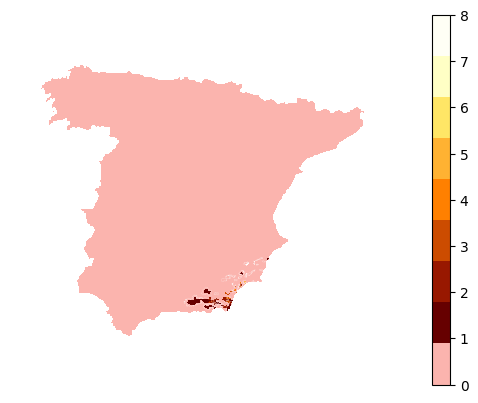

In [ ]:
# Open input data
vector_file = "LIC_Seeds.shp"
id_field = "OBJECTID"
raster_file = "2dRue.tif"
zNucleo = shapefile_rasterize(vector_file, raster_file, id_field)
with rasterio.open(raster_file, 'r') as rst:
    dRue = rst.read(1)

# Define parameters
# Size refers to kernel size. For each point on the edge of the seed, a kernel of a specific size will be drawn around that point. We recomend to use odd size numbers like [3,5,7,9].
size = 3
# Threshold refers to Oroloci's threshold, and is the value that defines if the land is similar to the LIC or not. It can go from 0 to 1.41, we highly recomend to use a threshold lower than 0.7 due to computation time.
threshold = 0.57317317

# Define output directory
directory = 'outputs/' + 'size (' + str(size) + ') - threshold (' + str(threshold) +')'
if not os.path.exists(directory):
    os.makedirs(directory)

# Run the growing algorithm
get_escenario_cero(zNucleo, dRue, size, threshold, directory)